In [ ]:
import torch
import torchvision as tv
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
import torch.nn as nn

## Datasets
PyTorch has a number of builtin datasets 
(all subclasses of [toch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) ):
[audio datasets](https://pytorch.org/audio/stable/datasets.html), [text datasets](https://pytorch.org/vision/stable/datasets.html)
, and what concerns us in this notebook, [image datasets](https://pytorch.org/text/stable/datasets.html)



In this notebook we will be using the MNIST dataset. It has a set of images of handwritten digits (0-9) with their corresponding labels. Furthermore, the dataset is divided into a training part and test part. The difference between the two is just the ```train``` parameter.

In [ ]:
train_data=tv.datasets.MNIST(root=".",download=True,train=True)
test_data=tv.datasets.MNIST(root=".",download=True,train=False)

In [ ]:
print("number of training samples={} and test samples={}".format(len(train_data),len(test_data)))

### Inspecting the data
Datasets are **iterable** objects. An [**iterable**](https://docs.python.org/3/library/functions.html#iter) is an object that supports either the **iterable** or **sequence** protocols.
An object supports the **sequence** protocol if it implements two methods
1. ```__getitem__(idx)```
1. ```__len()__```

The iterable protocol it needs to implement

1. ```__iter__```
1. ```__next__```

Note that if the ```__iter__``` method is implemented as a **generator** then there is no need for the ```__next__``` method.

There are two ways to implement an iterable: define a ```__getitem__``` or ```__iter__``` methods with the second version being the preferred one.
Example 1
```python
class A ():
    def __getitem__(self,idx):
        return idx
    def __len__(self):
        return 5
```

In [ ]:
r=range(2)
print(hasattr(r,'__iter__'))

In [ ]:
class A ():
    pass
    def __getitem__(self,idx):
       return idx
    def __len__(self):
         return 5
a=A()
itr=iter(a)


In [ ]:

class B():
    def __iter__(self):
        for i in range(12,14):
            yield i
class C():
    def __init__(self):
        self.max=5
    def __iter__(self):
        self.c=0
        return self
    def __next__(self):
        if self.c>=self.max:
            raise StopIteration
        self.c+=1
        return self.c
c=C()
for x in c:
    print(x)
b=B()
print(hasattr(b,'__next__'))
# print(hasattr(b,'__iter__'))
#for x in a:
#    print(x)
#for y in b:
#    print(y)
# itr=iter(b)
# while True:
#     try:
#         a=next(itr)
#     except StopIteration:
#         break
#     print(a)


## Inspect the data
It is good practice to inspect the data before using it, For example: their data types, dimensions and other properties. In this case the data is a set of (image,label) pairs. We use the ```iter``` method to retrieve one pair at a time.

In [ ]:
itr=iter(train_data)
x,y=next(itr)
print(type(x),type(y))

To use the images we need to convert them to PyTorch tensors. We can do this automatically when loading the datasets by providing a **transform** to the dataset object. There are many transforms provided by [```torchvision.transforms```](https://pytorch.org/vision/0.11/transforms.html) but in this notebook we only need ```ToTensor```.

In [ ]:
train_data=tv.datasets.MNIST(".",download=True,train=True,transform=ToTensor())
test_data=tv.datasets.MNIST(".",download=True,train=False,transform=ToTensor())

In [ ]:
itr=iter(train_data)
x,y=next(itr)
print(type(x),type(y))

As can be seen from the above the images were transformed into torch tensors.

## Stochastic Gradient Descent
When we used gradient descent previously, we used all the available data to compute the gradient. If the dataset is large, as it is in this case, this method consumes a lot of memory. An alternative would be to approximate the gradient by computing it over a single data item or over a **subset** (a batch) of the data. This has two advantages
1. Uses a lot less memory
1. Introduces some randomness that prevents our algorithm from being stuck in a local minimum

PyTorch offers a useful class, ```DataLoader```, to retrieve batches of data. To do so we need to pass it the dataset and specify the batch size as shown below. The other parameters are as follows
1. ```num_workers``` specifies the number of threads to process the data in parallel
1. ```shuffle``` specifies if the data set is shuffled after every pass

In [ ]:
train_loader=DataLoader(train_data,batch_size=32,num_workers=2, shuffle=True)
test_loader=DataLoader(test_data,batch_size=32,num_workers=2,shuffle=False)

As we did before we retrieve a single item using an iterator. In this case an item is a **batch**.
Note that the MNIST images are grayscale (one channel) with size 28x28.

In [ ]:
itr=iter(train_loader)
b,l=next(itr)
print("b is of type={} and size={}".format(type(b),b.size()))
print("l is of type={} and size={}".format(type(l),l.size()))


## Feedforward Neural Network

A feedforward neural network is composed of a sequence of layers, each composed of multiple nodes. The inputs to a node in layer ```L``` are the outpus of **all** nodes in the preceding layer ```L-1```. The structure of a 3 layer network is shown below.

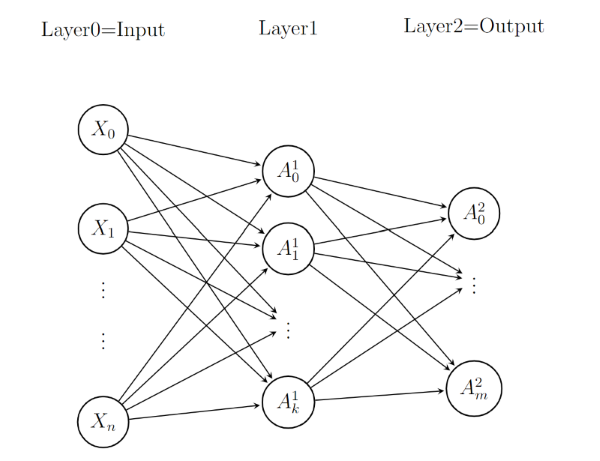

Let $A^k_i$, $i=0\ldots m$ be the values at layer $k$ then for each node in layer $k+1$ is computed as follows
\begin{align*}
Z^k_j&=b^k_j+\sum_i w^k_{ji}\times A^k_i \\
A^k_j&=f(Z^k_j)
\end{align*}

where

1. $w^k_{ji}$ are the weights, to be optimized.
1. $b^k_j$ are the biases, to be optimized.
1. $f$ is some non-linear function
1. $A^0_j$ are the inputs


### Why non-linear activation function?

In the absence of  the non-linear activation function  the computation of each layer becomes a linear transformation.

In that case, regardless of the number of layers, the computation would be equivalent to a single layer

### Feedforward in PyTorch

We can create layers (minus the non-linear function) using PyTorch's ```torch.nn.Linear``` class.

```python
torch.nn.Linear(in_features,out_features)
```

With the parameters initialized from a normal distribution.

### Example Computation

Each MNIST image has dimensions (1,28,28). We need to **flatten** the image before we use it as input to the feedforward network. Let us start with an example with a single layer. 
For each input batch we need to flatten it, which is accomplished with the ```.view``` method. Since we are using batches of size 32 then

```batch.view(32,-1)```

Would flatten all the images in the batch. Therefore an input of (32,1,28,28) would be converted to (32,784)

In [ ]:
# create an iterator
itr=iter(train_loader)
# retrieve the next (img,label) batch of pairs
imgs,labels=next(itr)
print("before flattening the size is {}".format(imgs.size()))
input=imgs.view(32,-1)
print("After flattining the size is {}".format(input.size()))

Now suppose we construct a layer that has 10 outputs (and 784 inputs to feed it the data)

In [ ]:
l=torch.nn.Linear(784,10)
itr=iter(l.parameters())
w=next(itr)
print("parameters of size {}".format(w.size()))
b=next(itr)
print("bias is of size {}".format(b.size()))
# apply the layer to the input
output=l(input)
print("output size is {}".format(output.size()))

## Activation function revisited

There are many different activation functions in use. Here we list two of the most common.
1. Sigmoid
1. ReLU

The sigmoid is usually used as the activation of the last layer since it has values in the range (0,1). 
Recall
\begin{align*}
\sigma(z)=\frac{1}{1+e^{-z}}
\end{align*}

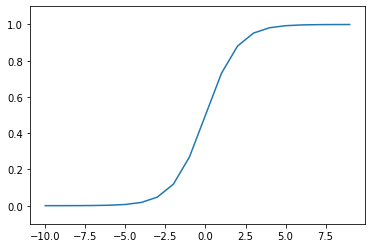

In [40]:
import math
import matplotlib.pyplot as plt
def sigmoid(z):
    return 1./(1.+math.exp(-z))
y=[sigmoid(x) for x in range(-10,10)]
plt.ylim(-.1,1.1)
plt.plot(range(-10,10),y)

As one can see, the sigmoid gets flat very quickly (in both direction).
The regions where the sigmoid approaches 1 can cause problems in learning since its gradient vanishes. 
This is why it is not often used in the intermediate layers.

A more popular non-linear activation for the intermediate layers is the ReLU which has a simple definition:
1. ReLU(x)=x  for $x\ge 0$
1. ReLU(x)=0  otherwise

## PyTorch Module

It is convenient to encapsulate all the network layers in a single class that inherit from ```nn.Module```

1. The layers are created in the ```__init__``` method
1. The application of the layers to the input is performed in the ```forward()``` method
1. In the example below we use 4 layers (including input/output)
1. There is no particular reason for the choice of the number/size of the layers. 

In [ ]:
input_size=28*28
hidden_size1=128
hidden_size2=64
output_size=10

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.layer1=nn.Linear(input_size,hidden_size1)
    self.layer2=nn.Linear(hidden_size1,hidden_size2)
    self.layer3=nn.Linear(hidden_size2,output_size)
    self.relu=nn.ReLU()
  def forward(self,x):
    x=x.view(x.size()[0],-1)
    x=self.layer1(x)
    x=self.relu(x)
    x=self.layer2(x)
    x=self.relu(x)
    x=self.layer3(x)

    return x


In [ ]:
# Example output
itr=iter(train_loader)
imgs,labels=next(itr)
model=Net()
output=model(imgs)
output.size()

## Softmax and Cross Entropy loss

The classification problem with $C$ possible classes is a straightforward generalization of the binary classification that we have encountered before.
For a given input $x$, let the output of our neural network be a $C$-dimension vector, $\hat{y}$, with $C$, denoting the number of classes. The probability that the input $x$ belongs to class $i\in C$ is given by the **softmax** function:

\begin{align*}
P(i)=\frac{e^{\hat{y}_i}}{\sum_{c=1}^C e^{\hat{y}_c}}
\end{align*}

If the **true** label is class $j$ then the **cross entropy** loss is given by
\begin{align*}
\mathcal{L}=-\log{\frac{e^{\hat{y}_j}}{\sum_{c=1}^C e^{\hat{y}_c}}}
\end{align*}

### Intuition behind cross entropy loss

Mathematics aside, one can understand the idea behind the cross entropy loss by considering a couple of edge cases. Suppose that, for input $x$, the network outputs a vector containing $C$ values $[y_0,\ldots,y_{c-1}]$ and the "true" label corresponding to the input is $j$

1. If network predicted a high probability for label $j$, i.e.  $e^{\hat{y}_j}\gg e^{\hat{y}_k}$ for all $k\ne j$ then  $\sum_{c=1}^C e^{\hat{y}_c}\approx e^{\hat{y}_j}$ and we can write the loss
\begin{align*}
\mathcal{L}=-\log{\frac{e^{\hat{y}_j}}{\sum_{c=1}^C e^{\hat{y}_c}}}\approx -\log\frac{e^{\hat{y}_j}}{e^{\hat{y}_j}}=0
\end{align*}
2. If the network predicted a low probability for label $j$ then $\sum_{c=1}^C e^{\hat{y}_c}\gg e^{\hat{y}_j}$ so that $\frac{e^{\hat{y}_j}}{\sum_{c=1}^C e^{\hat{y}_c}}\rightarrow 0$ and the loss function becomes
\begin{align*}
\mathcal{L}=-\log{\frac{e^{\hat{y}_j}}{\sum_{c=1}^C e^{\hat{y}_c}}}\approx -\lim_{\epsilon\rightarrow 0}\log\epsilon\rightarrow \infty
\end{align*}


Below are a few examples of how the **cross entropy** loss is computed in PyTorch

In [38]:
# Example cross entropy 1
loss_fn=nn.CrossEntropyLoss()
y=torch.tensor([1.,12.,3.,4.])
loss=loss_fn(y,torch.tensor(1))
print("loss when the correct label is predicted with high prob.={:.4f}".format(loss.item()))
# Manually computing the cross entropy
norm=0.
for i in range(4):
    norm+=torch.exp(y[i])
print("\"Manual\", PyTorch")
print("{:.4f}  {:.4f}".format(-torch.log(torch.exp(y[1])/norm).item(),loss.item()))
# Network did not predict the correct label
y=torch.tensor([5.,1.,8.,12.])
loss=loss_fn(y,torch.tensor(1))
print("loss when the correct label has low prob.={:.4f}".format(loss.item()))

loss when the correct label is predicted with high prob.=0.0005
"Manual", PyTorch
0.0005  0.0005
loss when the correct label has low prob.=11.0191


When using batches, by default PyTorch averages the loss over the batches

In [39]:
# Example cross entropy 2
# no averaging 
loss_fn=nn.CrossEntropyLoss(reduction='none')
y=torch.tensor([[1.,2.,3.,4.],[5,6,7,8]])
print("no average loss=",loss_fn(y,torch.tensor([1,3])))
loss_fn=nn.CrossEntropyLoss()
print("default loss=",loss_fn(y,torch.tensor([1,3])))


no average loss= tensor([2.4402, 0.4402])
default loss= tensor(1.4402)


### Why didn't we use softmax in our model?

There are two places where the output of softmax is needed
1. In the computation of the loss
1. In the prediction of the correct label corresponding to the input

In the first case, PyTorch ```CrossEntropyLoss``` implicitly uses softmax and therefore assumes that we are passing it raw "logits".

In the second case, there is no need to compute softmax since our prediction selects the index of the output that has the highest probability. Because softmax is a monotonically increasing function the index that has the largest logit will have the largest probability.



In [ ]:
model=Net()
print(model)

In [ ]:
   
def accuracy(model,batch):
    imgs,labels=batch
    outputs=model(imgs)
    _,pred=torch.max(outputs,dim=1)
    acc=torch.sum(pred==labels).item()
    return torch.tensor(acc/len(labels))
  
@torch.no_grad() 
def evaluate(model,loader):
    model.eval()
    acc=[accuracy(model,batch) for batch in loader]
    acc=torch.stack(acc).mean()
    return acc 

In [ ]:
if torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')

def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(b,device) for b in data]
    return data.to(device,non_blocking=True)
    
to_device(model,device)
class DataLoaderOnDevice():
    def __init__(self,loader,device):
        self.device=device
        self.loader=loader
    def __iter__(self):
        for batch in self.loader:
            yield to_device(batch,self.device)

    def __len__(self):
        return len(self.loader)

train_loader=DataLoaderOnDevice(train_loader,device)
test_loader=DataLoaderOnDevice(test_loader,device)

In [ ]:
import torch.optim as optim
epochs=10
optimizer=optim.SGD(model.parameters(),lr=0.01)
loss_fn=nn.CrossEntropyLoss()
running_loss=0.0
for epoch in range(epochs):
  model.train()
  for i,data in enumerate(train_loader):
    optimizer.zero_grad()
    img,label=data
    output=model(img)
    loss=loss_fn(output,label)
  
    loss.backward()
    optimizer.step()
    running_loss=0.99*running_loss+0.01*loss.item()
  print("loss {:.4f}".format(running_loss))
  val_acc=evaluate(model,test_loader)
  train_acc=evaluate(model,train_loader)
  print("train accuracy={:.3f}, valid accuracy={:.3f}".format(train_acc,val_acc))